<a href="https://colab.research.google.com/github/GaneshBade/Algorithmic-Trading-Python-for-finance/blob/main/Market_Basket_Analysis_Using_FP_growth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Market Basket Analysis using Instacart Grocery Dataset

A key technique to uncover associations between different items is known as market basket analysis.

# Setup Pyspark in Colab

In [1]:
!pip install pyspark

     |████████████████████████████████| 212.4 MB 71 kB/s 
     |████████████████████████████████| 198 kB 40.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=c85c5049f9951b872432eb8494949c9a9f130546c4e84056902bcd10e3022219
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Mount Google Drive locally

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive
!ls -lrt
%cd MyDrive
!ls -lrt
%cd Instacart\ Market\ Basket\ Analysis
!ls -lrta
!pwd

/content/drive
total 8
drwx------ 2 root root 4096 Aug 15 06:52 Othercomputers
drwx------ 4 root root 4096 Aug 15 06:52 MyDrive
/content/drive/MyDrive
total 8
drwx------ 2 root root 4096 Jun 21 13:46 'Colab Notebooks'
drwx------ 2 root root 4096 Aug 14 14:47 'Instacart Market Basket Analysis'
/content/drive/MyDrive/Instacart Market Basket Analysis
total 696652
-rw------- 1 root root       270 May  2  2017 departments.csv
-rw------- 1 root root      2603 May  2  2017 aisles.csv
-rw------- 1 root root   2166953 May  2  2017 products.csv
-rw------- 1 root root  24680147 May  2  2017 order_products__train.csv
-rw------- 1 root root 108968645 May  2  2017 orders.csv
-rw------- 1 root root 577550706 May  2  2017 order_products__prior.csv
/content/drive/MyDrive/Instacart Market Basket Analysis


In [5]:
departments_path = '/content/drive/MyDrive/Instacart Market Basket Analysis/departments.csv'
aisles_path = '/content/drive/MyDrive/Instacart Market Basket Analysis/aisles.csv'
products_path = '/content/drive/MyDrive/Instacart Market Basket Analysis/products.csv'
order_products_train_path = '/content/drive/MyDrive/Instacart Market Basket Analysis/order_products__train.csv'
orders_path = '/content/drive/MyDrive/Instacart Market Basket Analysis/orders.csv'
order_products_prior_path = '/content/drive/MyDrive/Instacart Market Basket Analysis/order_products__prior.csv'

In [6]:
aisles = spark.read.csv(path=aisles_path, header=True, inferSchema=True)
departments = spark.read.csv(path=departments_path, header=True, inferSchema=True)
products = spark.read.csv(path=products_path, header=True, inferSchema=True)
order_products_train = spark.read.csv(path=order_products_train_path, header=True, inferSchema=True)
orders = spark.read.csv(path=orders_path, header=True, inferSchema=True)
order_products_prior = spark.read.csv(path=order_products_prior_path, header=True, inferSchema=True)


In [7]:
aisles.printSchema()
aisles.show(truncate=False, n=5)
departments.printSchema()
departments.show(truncate=False, n=5)
products.printSchema()
products.show(truncate=False, n=5)
orders.printSchema()
orders.show(truncate=False, n=5)
order_products_train.printSchema()
order_products_train.show(truncate=False, n=5)
order_products_prior.printSchema()
order_products_prior.show(truncate=True, n=5)

root
 |-- aisle_id: integer (nullable = true)
 |-- aisle: string (nullable = true)

+--------+--------------------------+
|aisle_id|aisle                     |
+--------+--------------------------+
|1       |prepared soups salads     |
|2       |specialty cheeses         |
|3       |energy granola bars       |
|4       |instant foods             |
|5       |marinades meat preparation|
+--------+--------------------------+
only showing top 5 rows

root
 |-- department_id: integer (nullable = true)
 |-- department: string (nullable = true)

+-------------+----------+
|department_id|department|
+-------------+----------+
|1            |frozen    |
|2            |other     |
|3            |bakery    |
|4            |produce   |
|5            |alcohol   |
+-------------+----------+
only showing top 5 rows

root
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle_id: string (nullable = true)
 |-- department_id: string (nullable = true)

+--------

In [8]:
# Create Temporary tables
aisles.createOrReplaceTempView("aisles")
departments.createOrReplaceTempView("departments")
order_products_prior.createOrReplaceTempView("order_products_prior")
order_products_train.createOrReplaceTempView("order_products_train")
orders.createOrReplaceTempView("orders")
products.createOrReplaceTempView("products")

In [9]:
order_products_prior.createOrReplaceTempView("order_products_prior")

In [10]:
# print(f"aisles shape: {aisles.toPandas().shape}")
# print(f"departments shape: {departments.toPandas().shape}")
# # print(f"order_products_prior shape: {order_products_prior.toPandas().shape}")
# print(f"order_products_train shape: {order_products_train.toPandas().shape}")
# print(f"orders shape: {orders.toPandas().shape}")
# print(f"products shape: {products.toPandas().shape}")

In [11]:
orders_df = orders.toPandas()
orders_df['order_dow'].value_counts()

0    600905
1    587478
2    467260
5    453368
6    448761
3    436972
4    426339
Name: order_dow, dtype: int64

In [12]:
orders_df['day_of_week']=orders_df['order_dow'].map({0:'Sunday', 1:'Monday', 2:'Tuesday', 3:'Wensday', 4:'Thursday', 5:'Friday', 6:'Saturday'})
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,day_of_week
0,2539329,1,prior,1,2,8,NaN,Tuesday
1,2398795,1,prior,2,3,7,15.0,Wensday
2,473747,1,prior,3,3,12,21.0,Wensday
3,2254736,1,prior,4,4,7,29.0,Thursday
4,431534,1,prior,5,4,15,28.0,Thursday


Lets explore orders dataframe

In [13]:
query = '''
select count(order_id) as total_orders,
(case
    when order_dow = '0' then 'Sunday'
    when order_dow = '1' then 'Monday'
    when order_dow = '2' then 'Tuesday'
    when order_dow = '3' then 'Wendsday'
    when order_dow = '4' then 'Thursday'
    when order_dow = '5' then 'Friday'
    when order_dow = '6' then 'Saturday'
end) as day_of_week
from orders
group by day_of_week
order by total_orders desc
;
'''
df = spark.sql(query).toPandas()

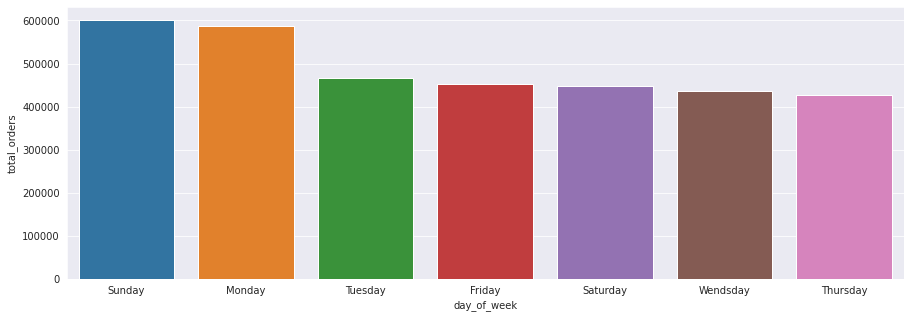

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='day_of_week', y='total_orders', data=df)

Above barplot shows that Sunday and Monday are very busy day as compare to rest of week days

In [15]:
query = '''
select count(order_id) as total_orders, order_hour_of_day as hour_of_day
from orders
group by 2
order by 2 asc
;
'''
df = spark.sql(query).toPandas()

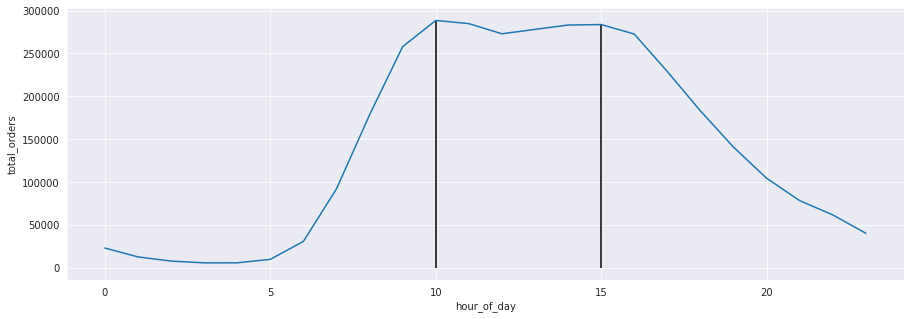

In [16]:
plt.figure(figsize=(15, 5))
ax = sns.lineplot(x='hour_of_day', y='total_orders', data=df, markers=True)
plt.vlines(x=10, ymin=0, ymax=df['total_orders'].max())
plt.vlines(x=15, ymin=0, ymax=df[df['hour_of_day'] == 15])
plt.show()

Above graph shows pick hours or rush hours are in between 10.00 AM - 15.00 PM 

In [17]:
query='''
select d.department, count(1) as counter
from departments as d, products as p
where d.department_id=p.department_id
group by d.department
order by counter desc
;
'''
df = spark.sql(query).toPandas()

In [18]:
df.head()

,department,counter
0,personal care,6563
1,snacks,6264
2,pantry,5371
3,beverages,4365
4,frozen,4007


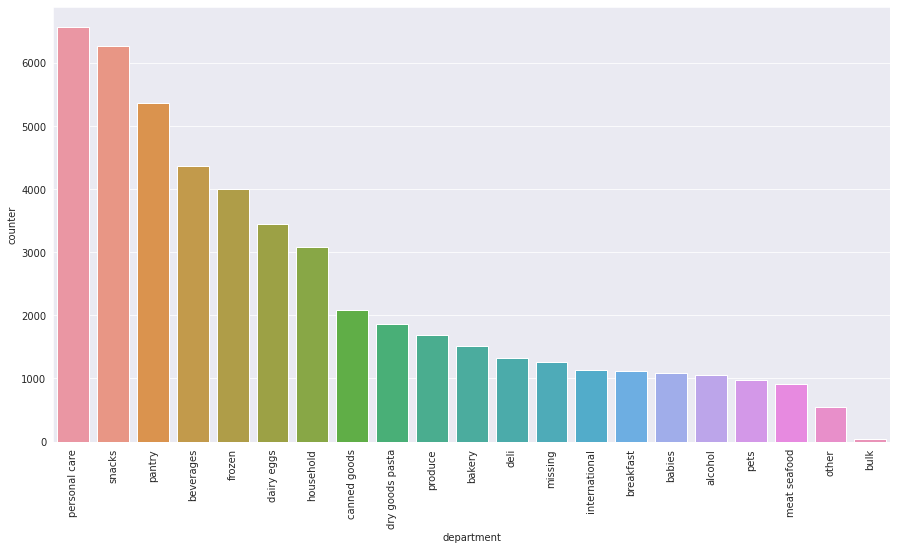

In [19]:
plt.figure(figsize=(15, 8))
ax = sns.barplot(x='department', y='counter', data=df)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.show()

It's looks like first 6 items are most popular amongst products

Let's find out the top 10 popular items across all products

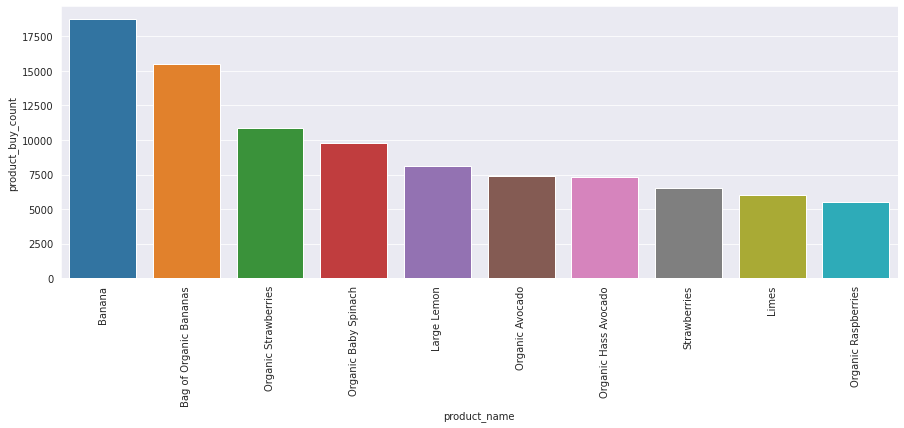

In [35]:
query='''
select op.product_id, p.product_name, count(1) as product_buy_count
from order_products_train op, products p
where op.product_id = p.product_id
group by 1, 2
order by product_buy_count desc
limit 10
;
'''
df = spark.sql(query).toPandas()

plt.figure(figsize=(15, 5))
ax = sns.barplot(x='product_name', y='product_buy_count', data=df)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.show()

Now, prepare data for FP-growth model

In [37]:
order_products_train.show(5)

+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       1|     49302|                1|        1|
|       1|     11109|                2|        1|
|       1|     10246|                3|        0|
|       1|     49683|                4|        0|
|       1|     43633|                5|        1|
+--------+----------+-----------------+---------+
only showing top 5 rows



In [40]:
products.show(5, truncate=False)

+----------+-----------------------------------------------------------------+--------+-------------+
|product_id|product_name                                                     |aisle_id|department_id|
+----------+-----------------------------------------------------------------+--------+-------------+
|1         |Chocolate Sandwich Cookies                                       |61      |19           |
|2         |All-Seasons Salt                                                 |104     |13           |
|3         |Robust Golden Unsweetened Oolong Tea                             |94      |7            |
|4         |Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce|38      |1            |
|5         |Green Chile Anytime Sauce                                        |5       |13           |
+----------+-----------------------------------------------------------------+--------+-------------+
only showing top 5 rows



In [51]:
query='''
select op.order_id, op.product_id, p.product_name
from order_products_train op, products p
where op.product_id = p.product_id
;
'''
rawData = spark.sql(query)

In [44]:
rawData.head()

,order_id,product_id,product_name
0,1,49302,Bulgarian Yogurt
1,1,11109,Organic 4% Milk Fat Whole Milk Cottage Cheese
2,1,10246,Organic Celery Hearts
3,1,49683,Cucumber Kirby
4,1,43633,Lightly Smoked Sardines in Olive Oil


In [68]:
from pyspark.sql.functions import *
baskets = rawData.groupBy('order_id').agg(collect_set('product_name').alias('items'))
baskets.createOrReplaceTempView('baskets')
baskets.show(truncate=False)

+--------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|order_id|items                                                                                                                   

# Train FP-growth ML model (Frequent Pattern Mining Algorith)

In [84]:
query='''
select items from baskets
;
'''
baskets_ds = spark.sql(query).toDF('items')

In [85]:
baskets_ds.show(5, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|items                                                                                                                                     

In [100]:
from pyspark.ml.fpm import FPGrowth
fpGrowth = FPGrowth(itemsCol="items", minSupport=0.01, minConfidence=0.0)
model = fpGrowth.fit(baskets_ds)

Let's get most frequent itemsets

In [118]:
freqItemSets_df = model.freqItemsets.toPandas()

In [112]:
model.associationRules.sort(desc('confidence')).show(truncate=False)

+------------------------+------------------------+-------------------+------------------+--------------------+
|antecedent              |consequent              |confidence         |lift              |support             |
+------------------------+------------------------+-------------------+------------------+--------------------+
|[Organic Hass Avocado]  |[Bag of Organic Bananas]|0.33182503770739064|2.8125601661853374|0.018443856747631642|
|[Organic Raspberries]   |[Bag of Organic Bananas]|0.32095203750450774|2.720400251222801 |0.013566142566439803|
|[Organic Raspberries]   |[Organic Strawberries]  |0.3011179228272629 |3.6267102566772844|0.012727785441547455|
|[Strawberries]          |[Banana]                |0.29996920234062213|2.101818811807684 |0.01484654253900266 |
|[Organic Avocado]       |[Banana]                |0.2990956944256985 |2.0956983322600378|0.016889085352376744|
|[Organic Strawberries]  |[Bag of Organic Bananas]|0.28217367358178813|2.3917135359814496|0.023428270926